<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Simple Convolutional Neural Network (CNN) Scale Demonstration

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 


##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

#### Honggeun Jo, Graduate Candidate, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/honggeun-jo/?originalSubdomain=kr) | [GitHub](https://github.com/whghdrms) | [Twitter](https://twitter.com/HonggeunJ)


### Workflow for training CNN to classify images

This workflow demonstrates design and training of a CNN model to classify for a variety of synthetic labeled images.

* a very simple, fast run time, well-documented toy problem to support experiential learning 

* I demonstrate the impact of scale of the image features, the ability to work with multiple scales  

___

**Can we train a simple CNN to detect the extent of a randomly located artifact in a set of uniform images**?
___

We design a simple network with convolution over multiple filters (variable size) to demonstrate this.

### Convolutional Neural Networks

Extension of the artifical neural network, based on the visual cortex:

* extraction of features from overlapping receptive fields, over a hierarchy (not shown) and then recompose the whole image, our perception.

* We don’t perceive all the ‘pixels’, our visual cortex interprets and summarizes patterns. Let’s make a machine to do this.

**Regularization**: a constraint to reduce the sensitivity of the model to the data, to reduce model variance

Receptive Fields

* the use of receptive fields is a form of regularization

* massive reduction in connections, weights and model parameters

* effectively shrinking these potential weights to zero

* while integrating / focusing on pixel patterns!

We have access to operators to move from layer to layer (feature maps to feature maps) in our convolutional neural networks.  The common operators include:

* **Convolution** – a weighting window / filter designed to extract features

* **Pooling** – reduction in dimensionality, increase local translation invariance 

* **Depth-wise Pooling, Down Sampling** – 1x1 filter that combine channels, feature maps

* **Activation** – use of an activation function to apply a nonlinear transformation to impart nonlinearity to the system

* **Full-connected, feed forward** – see previous lecture 

For a demonstration of all of these operators, check out this [Python Jupyter Notebook](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Convolution_Operators.ipynb)

#### Objective 

Michael teaches data analytics, geostatistics and machine learning. To demonstrate the basic construction of a convolutional neural networks, training and prediction.  

* Michael uses these examples in my lecture notes, see the lecture posted on my YouTube channel.

* for any to gain experiential learning with the nuts and bolts of convolutional neural networks

Note, we only demonstrate the basics of construction, training and prediction. There is much more about the design and training that we do not cover.

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Load the required libraries

The following code loads the required libraries.

We will need some standard packages. These should have been installed with Anaconda 3.
* [numpy](https://numpy.org/): To generate arrays <br>
* [matplotlib](https://matplotlib.org/): Vilsualization purpose <br>
* sklearn: for model metrics, confusion matrices, one hot encoder

We also will need tensor flow, this will require an install as it is not available in Anaconda
* [tensorflow > 2.0.0](https://www.tensorflow.org/learn): Design, compile and train neural network models

In [38]:
import numpy as np                                      # ndarrays for gridded data, our images
import matplotlib.pyplot as plt                         # plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix # model metrics
from scipy.ndimage import gaussian_filter               # Gaussian filter for smoothing our images
from sklearn.preprocessing import OneHotEncoder         # one hot encoder for our response feature
import random                                           # pseudo-random values

import tensorflow as tf                                 # import tensor flow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

assert tf.__version__.startswith('2.')                  # this will give you error if tensorflow < 2.0
tf.keras.backend.set_floatx('float32')                  # default float to be 'float32' (Tensorflow only works with float8, 16, 32)

physical_devices = tf.config.list_physical_devices('GPU') # constrain memory use to avoid a CUDNN_STATUS_ALLOC_FAILED error
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed = 73073                                            # set the random number seed for repeatability
np.random.seed(seed)                                    

cmap = plt.cm.inferno                                   # color map for plots

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # there are a lot of retrace warnings we can ignore


#### Check Your Hardware

Let's confirm that we have access to a properly configured GPU.

* you should see a 'physcial_device:GPU' device listed below

In [39]:
tf.config.list_physical_devices('GPU')                  # check for a properly configured GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

No worries if you don't have a configured GPU as this workflow was tested in a CPU only environment and it ran.

* likely a longer run time

#### Define Functions

Let's define a couple of convenience functions for workflow brevity and read-ability

* train and test accuracy over epochs performance plots
* train and test prediction acurracy, confusion matrix plots
* visualize the trained CNN filters
* visualize the feature maps for a specific image classification case
* visualize the last layer, the probability output from the softmax activation function

In [40]:
def model_performance(history,nepoch):                  # visualize error and loss, training and testing over Epochs     
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],c='red')
    plt.plot(history.history['val_loss'],c='black')
    plt.title('CNN Model Loss')
    plt.ylabel('Testing Categorical Entropy'); plt.xlabel('Epoch'); plt.grid()
    plt.legend(['train', 'test'], loc='upper right'); plt.xlim([0,nepoch]); plt.ylim([0,1])
    
    plt.subplot(1,2,2)
    plt.plot(history.history['sparse_categorical_accuracy'],c='red')
    plt.plot(history.history['val_sparse_categorical_accuracy'],c='black')
    plt.title('CNN Model Accuracy')
    plt.ylabel('Testing Proportion Correct Classification'); plt.xlabel('Epoch'); plt.grid()
    plt.legend(['train', 'test'], loc='upper right'); plt.xlim([0,nepoch]); plt.ylim([0,1])
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.3)
    plt.show()
    
def model_cross_validation(model,X_train,X_test,y_train,y_test): # visualize misclassification error for training and testing data 
    y_train_predict = model.predict(X_train[:,:,:,0].reshape([ntrain,nx,ny,-1])) # predict over the training images
    y_train_predict = np.argmax(y_train_predict,axis = 1) # assign the maximum probability category
    
    y_test_predict = model.predict(X_test[:,:,:,0].reshape([ntest,nx,ny,-1])) # predict over the testing images 
    y_test_predict = np.argmax(y_test_predict,axis = 1) # assign the maximum probability category
    
    plt.subplot(121)                                                
    train_confusion_matrix = confusion_matrix(y_train,y_train_predict) # calculate and plot train confusion matrix
    train_confusion_matrix = train_confusion_matrix/np.sum(train_confusion_matrix) 
    im = plt.imshow(train_confusion_matrix,cmap=cmap,vmin=0.0,vmax=1.0); plt.xlabel('Prediction'); plt.ylabel('Truth'); plt.title('Training Confusion Matrix')
    ax = plt.gca(); ax.set_xticks([0,1,2,3]); ax.set_xticklabels(name)
    ax.set_yticks([0,1,2,3]); ax.set_yticklabels(name)
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 1.0, 5))
    cbar.set_label('Proportion', rotation=270, labelpad=20)
    
    plt.subplot(122)
    test_confusion_matrix = confusion_matrix(y_test,y_test_predict) # calculate and plot train confusion matrix
    test_confusion_matrix = test_confusion_matrix/np.sum(test_confusion_matrix) 
    im = plt.imshow(test_confusion_matrix,cmap=cmap,vmin = 0,vmax = 1.0)
    plt.xlabel('Prediction'); plt.ylabel('Truth'); plt.title('Testing Confusion Matrix')
    ax = plt.gca(); ax.set_xticks([0,1,2,3]); ax.set_xticklabels(name)
    ax.set_yticks([0,1,2,3]); ax.set_yticklabels(name)
    cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 1.0, 5))
    cbar.set_label('Proportion', rotation=270, labelpad=20)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.3)
    plt.show()
    
    print(f'            Train   Test')                  # print a table with train and test accuracy
    print(f'precision: {accuracy_score(y_train.flatten(), y_train_predict):.4f}, {accuracy_score(y_test.flatten(), y_test_predict):.4f}')
    print(f'recall:    {recall_score(y_train.flatten(), y_train_predict, average = "weighted"):.4f}, {recall_score(y_test.flatten(), y_test_predict, average = "weighted"):.4f}')
    print(f'f1 score:  {f1_score(y_train.flatten(), y_train_predict, average = "weighted"):.4f}, {f1_score(y_test.flatten(), y_test_predict, average = "weighted"):.4f}')

def visualize_filters(model):                           # visualize CNN filters
    for layer in model.layers:
        if 'conv' not in layer.name:                    # check if layers is a convolution
            continue
        filters, biases = layer.get_weights()
        fmin, fmax = filters.min(), filters.max()       # normalize the filter weights for visualization
        filters = (filters - fmin) / (fmax - fmin)
        print('Convolution Layer Name: ' + layer.name + ', Shape: ' + str(filters.shape[0]) + ' x ' + str(filters.shape[1]) + ', Number of Channels: ' + str(filters.shape[3]) + '.')
        nch = filters.shape[3]
        for ich in range(0,nch):
            plt.subplot(1,nch,ich+1)
            im = plt.imshow(filters[:,:,0,ich],cmap=cmap,vmin=0.0,vmax=1.0)
            ax = plt.gca(); ax.set_xticks([0,1,2]); ax.set_xticklabels([-1,0,1])
            ax.set_yticks([0,1,2]); ax.set_yticklabels([-1,0,1])
            cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0.0, 1.0, 5))
            cbar.set_label('Weights', rotation=270, labelpad=20)
            plt.title('Filter ' + str(ich+1))
        plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5*nch, top=0.5, wspace=0.4, hspace=0.3)
        plt.show()

def visualize_convolution_feature_maps(model,image):    # visualize CNN feature maps for a prediction case
    ilayer = -1
    for layer in model.layers:
        ilayer = ilayer + 1
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        model_trunc = Model(inputs=model.inputs, outputs=model.layers[ilayer].output) # truncate model to output feature maps
        feature_maps = model_trunc.predict(X[image,:,:,0].reshape([1,nx,ny,-1]))        
        print('Convolution Layer Name: ' + layer.name + ', Shape: ' + str(feature_maps.shape[1]) + ' x ' + str(feature_maps.shape[2]) + ', Number of Channels: ' + str(feature_maps.shape[3]) + '.')
    
        nch = feature_maps.shape[3]
        plt.subplot(1,nch+1,1)
        im = fig = plt.imshow(X[image,:,:,0], cmap=cmap)
        fig.axes.get_xaxis().set_visible(False); fig.axes.get_yaxis().set_visible(False)
        plt.title('Image ' + str(image) + ': ' + name[y[image]])
    
        for ich in range(0,nch):
            plt.subplot(1,nch+1,ich+2)
            im = plt.imshow(feature_maps[0, :, :, ich], vmin = -1,vmax = 1.0,cmap=cmap)
            ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
            plt.title('Convolution Feature Map ' + str(ich+1))
            cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-1.0, 1.0, 5))
            cbar.set_label('Feature Map Values', rotation=270, labelpad=20)
        
        plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5*nch, top=0.35, wspace=0.4, hspace=0.3)
        plt.show()
        
def visualize_max_pooling_feature_maps(model,image):    # visualize CNN feature maps for a prediction case
    ilayer = -1
    for layer in model.layers:
        ilayer = ilayer + 1
        # check for convolutional layer
        if 'max_pooling' not in layer.name:
            continue
        model_trunc = Model(inputs=model.inputs, outputs=model.layers[ilayer].output) # truncate model to output feature maps
        feature_maps = model_trunc.predict(X[image,:,:,0].reshape([1,nx,ny,-1]))        
        print('Max Pooling Layer Name: ' + layer.name + ', Shape: ' + str(feature_maps.shape[1]) + ' x ' + str(feature_maps.shape[2]) + ', Number of Channels: ' + str(feature_maps.shape[3]) + '.')
    
        nch = feature_maps.shape[3]
        plt.subplot(1,nch+1,1)
        fig = plt.imshow(X[image,:,:,0], cmap=cmap)
        fig.axes.get_xaxis().set_visible(False); fig.axes.get_yaxis().set_visible(False)
        plt.title('Image ' + str(image) + ': ' + name[y[image]])
    
        for ich in range(0,nch):
            plt.subplot(1,nch+1,ich+2)
            im = plt.imshow(feature_maps[0, :, :, ich], cmap=cmap)
            ax = plt.gca(); ax.set_xticks([]); ax.set_yticks([])
            plt.title('Max Pooling Feature Map ' + str(ich+1))
        
        plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5*nch, top=0.5, wspace=0.4, hspace=0.3)
        plt.show()

def visualize_last_layers(model, image):                # visualize last layer, category probabilities
    ilayer = -1; llayer = -1
    for layer in model.layers:                          # get the last dense layer
        ilayer = ilayer + 1
        # check for convolutional layer
        if 'dense' not in layer.name:
            continue
        else:
            llayer = ilayer
    if llayer == -1:
        print('No dense layer found'); return -1
    model_trunc = Model(inputs=model.inputs, outputs=model.layers[ilayer].output) # truncate model to output feature maps
    output_layer = model_trunc.predict(X[image,:,:,0].reshape([1,ny,nx,-1]))        

    plt.subplot(1,2,1)
    fig = plt.imshow(X[image,:,:,0], cmap=cmap)
    fig.axes.get_xaxis().set_visible(False); fig.axes.get_yaxis().set_visible(False)
    plt.title('Image ' + str(image) + ': ' + name[y[image]])

    plt.subplot(1,2,2)
    plt.title('Predicted Category Probabilities')
    plt.bar(x = ['1', '2','3','4'], height = output_layer.flatten()*100,color='red',edgecolor='black',alpha=0.2)
    plt.xlabel('Image Categories'); plt.ylabel('Probability (\%)')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.4, hspace=0.3)
    plt.show()              
        
def visualize_testing_predictions(model):               # visualize testing images and predicted probabilities 
    y_test_predict = model.predict(X_test[:,:,:,0].reshape([ntest,nx,ny,-1])) # predict over the testing images 
    y_test_predict_cat = np.argmax(y_test_predict,axis = 1) # assign the maximum probability category
    
    c, r = 4, 5                                         
    plt.figure(figsize = (10,10))
    for i in range(c*r):
        plt.subplot(r,c,i+1)
        fig = plt.imshow(X_test[i,:,:,0],cmap=cmap)
        fig.axes.get_xaxis().set_visible(False); fig.axes.get_yaxis().set_visible(False)
        icat = y_test_predict_cat[i]
        plt.title('Image ' + str(i) + ': ' + name[y_test[i,0]] + ', ' + str(np.round(y_test_predict[i,icat]*100,2)) + "% " + name[icat] )

            
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=1.6, wspace=0.01, hspace=0.3)
    plt.show()
    
def prediction_boxplot(model):                             # visualize the box plots for predicted probabilities by true category
    y_train_predict = model.predict(X_train[:,:,:,0].reshape([ntrain,ny,nx,-1])) # predict over the testing images 
    y_test_predict = model.predict(X_test[:,:,:,0].reshape([ntest,ny,nx,-1])) # predict over the testing images 
    c = 'red'
    
    plt.subplot(121)
    box_train = plt.boxplot([y_train_predict[:,0][y_train[:,0] == 0],y_train_predict[:,1][y_train[:,0] == 1],y_train_predict[:,2][y_train[:,0] == 2],y_train_predict[:,3][y_train[:,0] == 3]],labels=['1','2','3','4'])
    for i in range(1,4): plt.plot([i+.5,i+.5],[0,1],color='k',alpha=0.3,linestyle='--',linewidth=1)
    plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())   
    plt.ylim([0,1]); plt.ylabel('Prediction Probability of Correct Category'); plt.xlabel('Correct Image Label')
    plt.title('Training Image Correct Category Probabilities')
    
    plt.subplot(122)
    box_train = plt.boxplot([y_test_predict[:,0][y_test[:,0] == 0],y_test_predict[:,1][y_test[:,0] == 1],y_test_predict[:,2][y_test[:,0] == 2],y_test_predict[:,3][y_test[:,0] == 3]],labels=['1','2','3','4'])
    for i in range(1,4): plt.plot([i+.5,i+.5],[0,1],color='k',alpha=0.3,linestyle='--',linewidth=1)
    plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())   
    plt.ylim([0,1]); plt.ylabel('Prediction Probability of Correct Category'); plt.xlabel('Correct Image Label')
    plt.title('Testing Image Correct Category Probabilities')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3)
    plt.show()

### Convolutional Neural Network Example

Let's try a more complicated problem that will require our model to be location invariant and multiscale. 

* we will predict the length in pixels of a randomly located line in a constant image

#### Make a Random Simple Dataset

We make 100 simple images, 80 train and 20 test 12x12 binary, 0 and 1 images.

* we do this for a very rapid, fast toy problem

We make the random training and testing images and visualize some of the testing models with their labels.

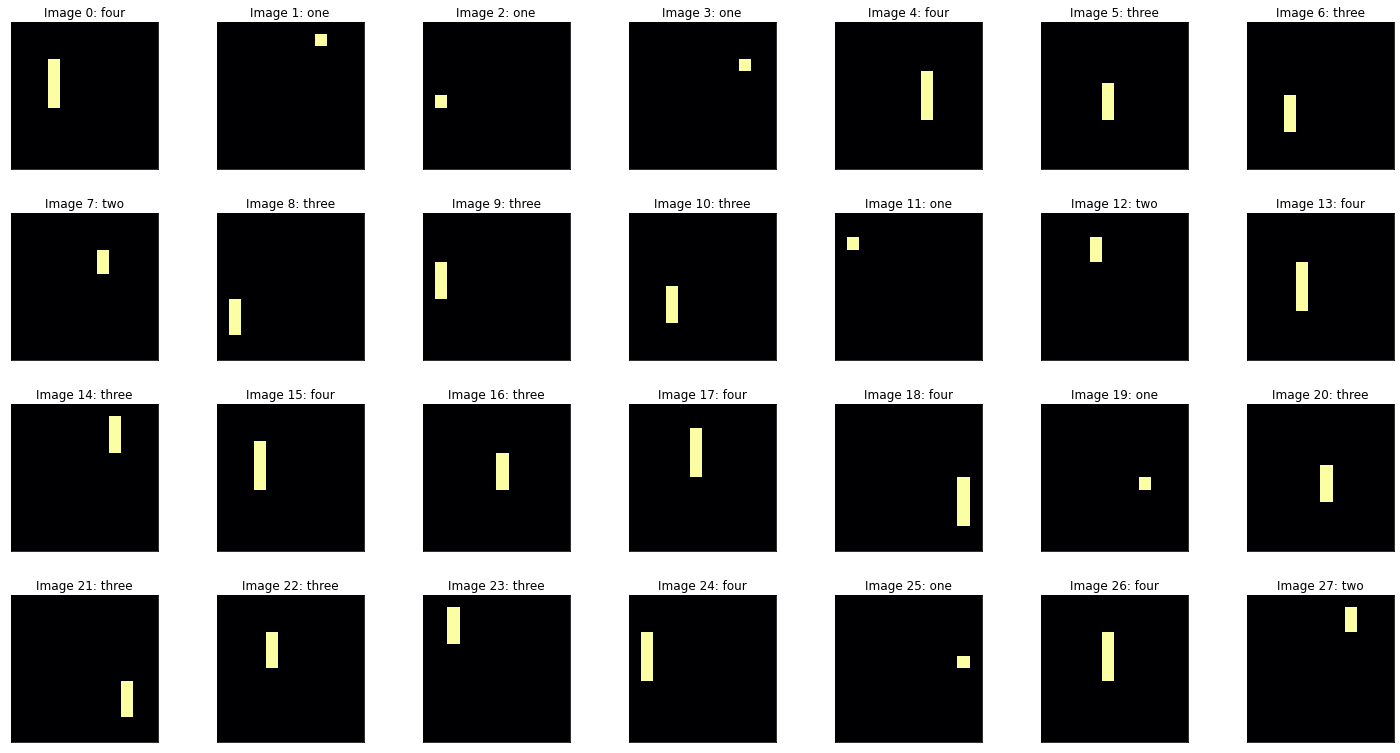

In [41]:
imin = 1; imax = 4                                      # parameters for the strength of the artifact, local multipliers
np.random.seed(seed)                                    # make synthetic images 
random.seed(seed)
nmodel = 100; px = 0.5; ptest = 0.2; nx = 12; ny = 12
ntest = int(nmodel*ptest); ntrain = nmodel - ntest
X = np.zeros([nmodel,nx,ny,1], dtype = float)
y = np.zeros(nmodel,dtype = int); name = np.array(['one','two','three','four'])
X_train = np.zeros([ntrain,nx,ny,1]); y_train = np.zeros(ntrain,dtype = int)
X_test = np.zeros([ntest,nx,ny,1]); y_test = np.zeros(ntest,dtype = int)

for i in range(0,nmodel):
    ilength = np.random.randint(imin, imax+1)
    ix = random.randint(1, nx-1-ilength-1); iy = random.randint(1, ny-2)
    X[i,ix:ix+ilength,iy,0] = 1.0
    y[i] = ilength-1

X_train = X[:ntrain,:,:,:]; X_test = X[ntrain:,:,:,:]
y_train = y[:ntrain]; y_test = y[ntrain:]
 
y_train = y_train.reshape(ntrain,-1)  
y_test = y_test.reshape(ntest,-1)         
            
c, r = 7, 4                                             # visualize labelled synthetic images
plt.figure(figsize = (10,10))
for i in range(c*r):
    plt.subplot(r,c,i+1)
    fig = plt.imshow(X[i,:,:,0],cmap=cmap)
    fig.axes.get_xaxis().set_visible(False); fig.axes.get_yaxis().set_visible(False)
    plt.title('Image ' + str(i) + ': ' + name[y[i]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.01, hspace=0.3)
plt.show()

#### Data Preprocessing

First, we should preprocess our data. 

* our images have a range of [0,1] so we don't need min-max normalization 

* also as catetories (e.g., y_train and y_test) are non-ordinal categorical variables, we will apply one-hot-encode to make the variable more compatible with a neural network model. 

* should we have ordinal categories (e.g.,'first','second', and 'third'), we can just use categorical number (i.e., integer encode). Following figure presents how one-hot-encode works in our example:  

| Response Feature Label  | Response Feature Value | 1 | 2 | 3 | 4 |
| :---------------------: | :---------------------: | :----: | :----: | :---: | :---: |
| One                     | 0                       | 1      | 0      | 0     | 0     |
| Four                    | 3                       | 0      | 0      | 0     | 1     |
| Three                   | 2                       | 0      | 0      | 1     | 0     |

To learn more about integer encoding and one-hot-encoding, please refer this lecture on [feature transformations](https://www.youtube.com/playlist?list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf).

In [42]:
enc = OneHotEncoder(categories = [[0,1,2,3]])               # 0 -> [1,0,0,0] (One) and 1 -> [0,1,0,0] (Two) etc.
enc.fit(y_train)
y_train_one_hot, y_test_one_hot = enc.transform(y_train), enc.transform(y_test)

#### Step 1. Define Classification Convolutional Neural Network 

Now we will define our convolutional neural network

* with keras frontend for tensor flow it is not too dificult to design our network

* the overall architure looks like this:

![image.png](attachment:image.png)

Image taken from [blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)) by Sumit Saha.

We cycle multiple layers of:

* convolution and activation with ReLU

* max pooling

After multiple cycles we have learning the features in the images we then finish with:

* flattening the feature into a 1D vector

* feed-forward, fully-connected artificial neural network with 2 output nodes for the probability of each category

As specified below the model includes:

* cycles of convolution with 3x3 kernels, stride = 1 or 2 for feature maps extent reduction (one half)

* feature maps transition from 12x12x1 [nx,ny,nchannel] over multiple steps to reduce featured map extent while increasing the depth and then flattens to a vector fully connected with 2 output nodes

In [43]:
def CNN_model():                                        # CNN design function
    model = tf.keras.Sequential()                       # define neural network model sequentially
    # Convolution Feature Map 1: (12x12x1) --> (12x12x6)
    model.add(layers.Conv2D(6, kernel_size=(5,5),strides=1,padding='same',input_shape=[ny,nx,1])) # -2 feature map extent given filter and no padding
    model.add(layers.ReLU())
    # Max Pooling Feature Map 1: (12x12x6) --> (6x6x6)    
    model.add(layers.MaxPooling2D((2, 2)))              # 1/2 extent
    # Convolution Feature Map 2: (6x6x6) --> (6x6x12)
    model.add(layers.Conv2D(12, kernel_size=(5,5),strides=1,padding='same',input_shape=[ny,nx,1])) # -2 feature map extent given filter and no padding
    model.add(layers.ReLU())
    # Max Pooling Feature Map 2: (6x6x12) --> (3x3x12)    
    model.add(layers.MaxPooling2D((2, 2)))              # 1/2 extent
    # Convolution Feature Map 3: (3x3x6) --> (3x3x24)
    model.add(layers.Conv2D(24, kernel_size=(3,3),strides=1,padding='same',input_shape=[ny,nx,1])) # -2 feature map extent given filter and no padding
    model.add(layers.ReLU())
    # Max Pooling Feature Map 3: (3x3x24) --> (1x1x12)    
    model.add(layers.MaxPooling2D((3, 3)))              # 1/2 extent
    model.add(layers.Flatten())
    #model.add(layers.Dense(96, activation='relu'))    
    # Output layer: (96) --> 4 (i.e., each node corresponds to the probability to be each class)
    model.add(layers.Dense(4, activation = 'softmax'))  # softmax activation function for classfier probabilities
    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    model.compile(loss='SparseCategoricalCrossentropy', metrics=['SparseCategoricalAccuracy'], optimizer='adam')
    return model

# EXAMPLES
# model.add(layers.Conv2D(3, kernel_size=(3,3), strides=1, input_shape=[nx,ny,1], padding="same")) #feature map padding
# model.add(layers.Conv2D(3, kernel_size=(3,3), strides=2, input_shape=[nx,ny,1], padding="same")) #feature map padding and extent reduction 1/2

#### Instantiate, Train the Convolutional Neural Network and Visualize the Model Performance in Training and Testing

This includes the following steps:

1. instantiate the CNN specified above 

2. train it with the 80 images in the training set

3. visualize the training and testing accuracy over the Epochs of training

4. write out the summary of the convolutional neural network

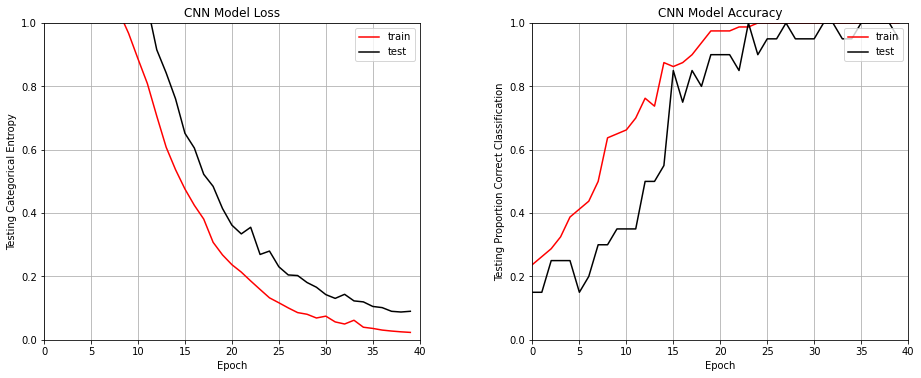

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 12, 12, 6)         156       
_________________________________________________________________
re_lu_33 (ReLU)              (None, 12, 12, 6)         0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 6, 6, 6)           0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 6, 6, 12)          1812      
_________________________________________________________________
re_lu_34 (ReLU)              (None, 6, 6, 12)          0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 3, 3, 12)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 3, 3, 24)        

In [44]:
nepoch = 40; batch_size = 5                             # training parameters

tf.random.set_seed(seed) 
model = CNN_model() 
history = model.fit(X_train[:,:,:,0].reshape([ntrain,ny,nx,-1]), y_train, 
                      batch_size=batch_size, epochs=nepoch, verbose=0, 
                      validation_data=(X_test[:,:,:,0].reshape([ntest,ny,nx,-1]), y_test))
    
model_performance(history,nepoch)                       # plot loss and accuracy over training Epochs
model.summary()                                         # write out the model summary

#### Predict with the Trained Convolutional Neural Network

Now we load the trained deeper CNN classifier and visualize its prediction performance

* we predict over the training and testing image datasets

* we predict with the category assigned the maximum probability by our model

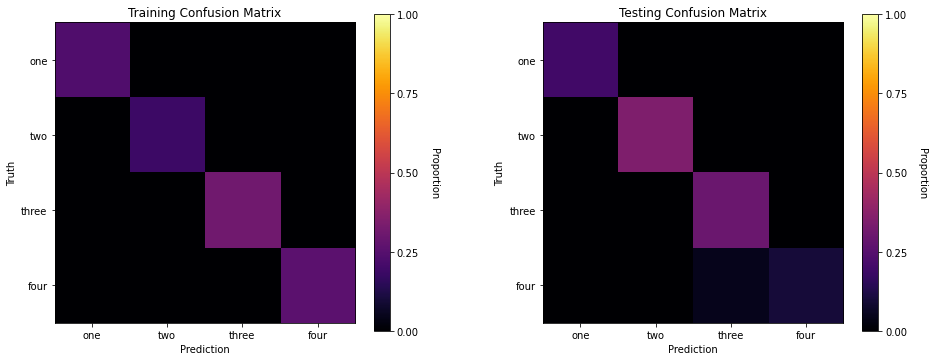

            Train   Test
precision: 1.0000, 0.9500
recall:    1.0000, 0.9500
f1 score:  1.0000, 0.9469


In [45]:
model_cross_validation(model,X_train,X_test,y_train,y_test) # predict and cross validate CNN classifier

### Interogate the Trained Convolutional Neural Network

#### Visualize the Convolution Filters

We can access and visualize the convolution weights. The follow code:

* loops over the layers and finds the convolution layers

* loops over the channels and plots all of the filters

Convolution Layer Name: conv2d_33, Shape: 5 x 5, Number of Channels: 6.


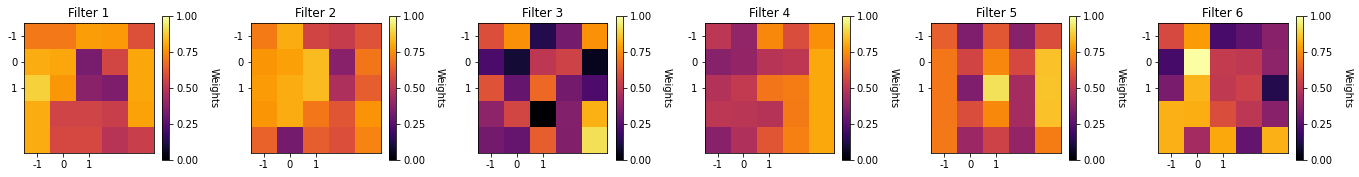

Convolution Layer Name: conv2d_34, Shape: 5 x 5, Number of Channels: 12.


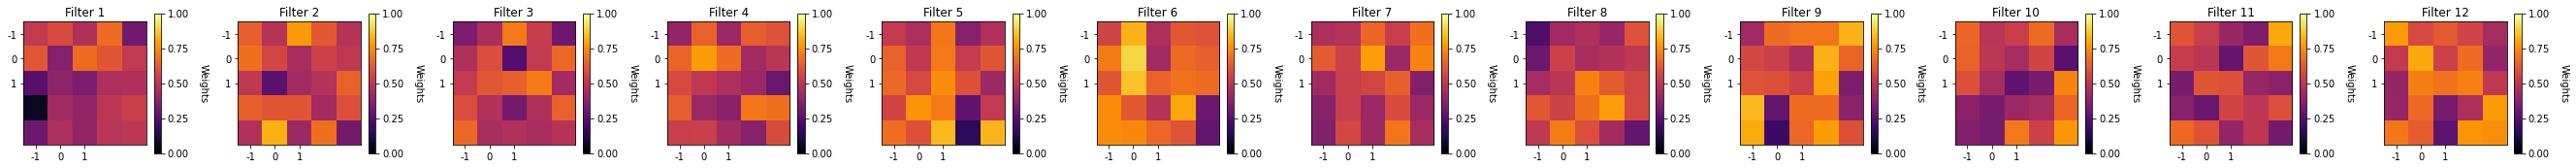

Convolution Layer Name: conv2d_35, Shape: 3 x 3, Number of Channels: 24.


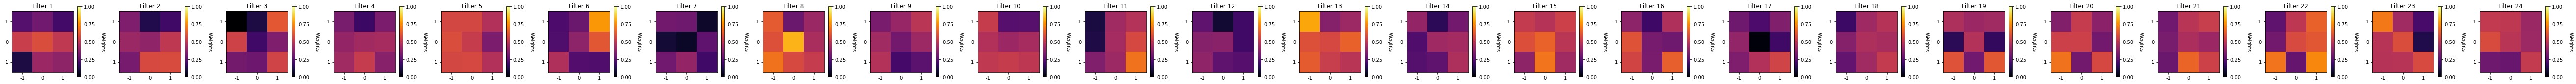

In [46]:
visualize_filters(model)                                # visualize all of the CNN filter weights

These are small 3 x 3 filters, but we can recognize some common structures:

* averaging / smoothing

* gradient

* edge / sharpen (sobel)

and combinations of these structures.

* it makes sense that averaging, edge and gradient filters would differentiate the random and smooth images.

#### Visualize the Convolution Feature Maps

Let's visualize the feature maps after each convolution for the classification prediction problem 

* you can specify the image below from 0 - 99

Convolution Layer Name: conv2d_33, Shape: 12 x 12, Number of Channels: 6.


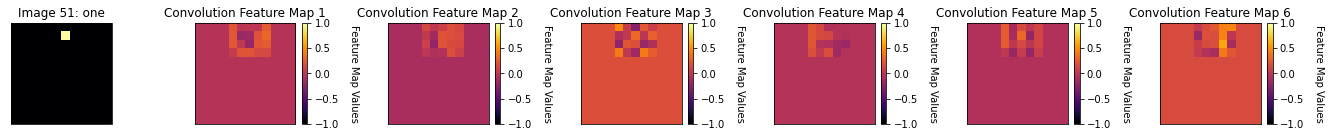

Convolution Layer Name: conv2d_34, Shape: 6 x 6, Number of Channels: 12.


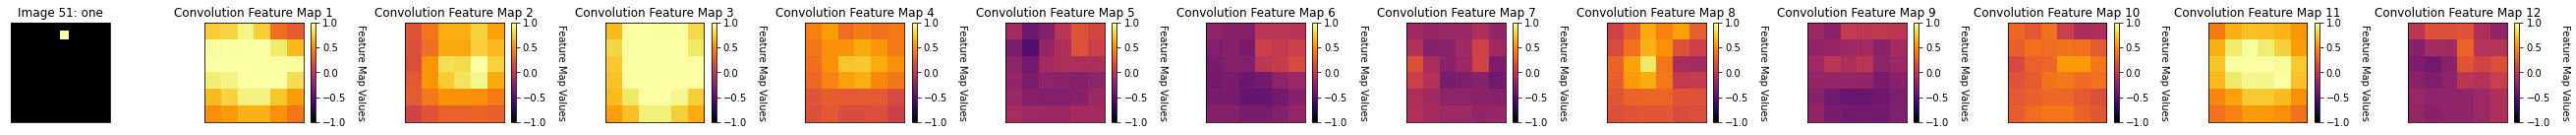

Convolution Layer Name: conv2d_35, Shape: 3 x 3, Number of Channels: 24.


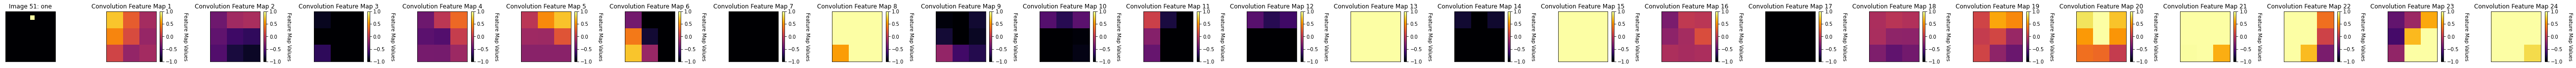

In [47]:
image = 51                                              # selected prediction case image from 0 - 99
visualize_convolution_feature_maps(model, image)        # function to visualize the convolution feature maps

These feature maps in each layer demonstrate the extraction of information from the original images:

* note the identification of the artifact over each convolution filter.

#### Visualize the Max Pooling Feature Maps

Let's visualize the feature maps after max pooling operations for our classification prediction problem.

* you can specify the image below from 0 - 99

Max Pooling Layer Name: max_pooling2d_33, Shape: 6 x 6, Number of Channels: 6.


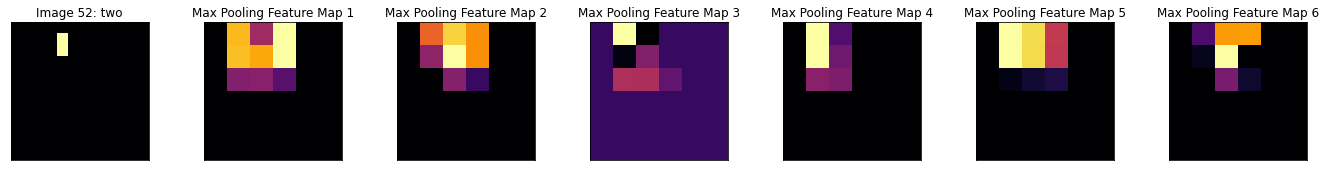

Max Pooling Layer Name: max_pooling2d_34, Shape: 3 x 3, Number of Channels: 12.


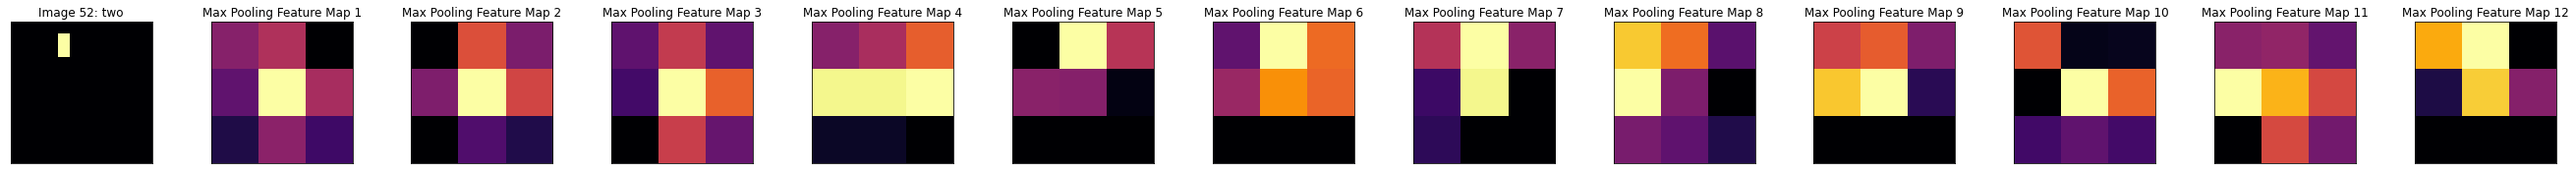

Max Pooling Layer Name: max_pooling2d_35, Shape: 1 x 1, Number of Channels: 24.


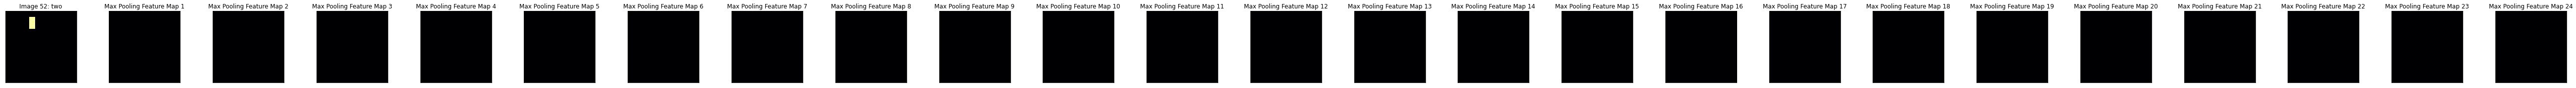

In [48]:
image = 52                                              # selected prediction case image from 0 - 99
visualize_max_pooling_feature_maps(model, image)        # function to visualize the max pooling feature maps


#### Visualize the Output Layer

Let's visualize the output layer which contains the probability to be each categories (e.g., random or smooth)

* you can specify the image below from 0 - 99

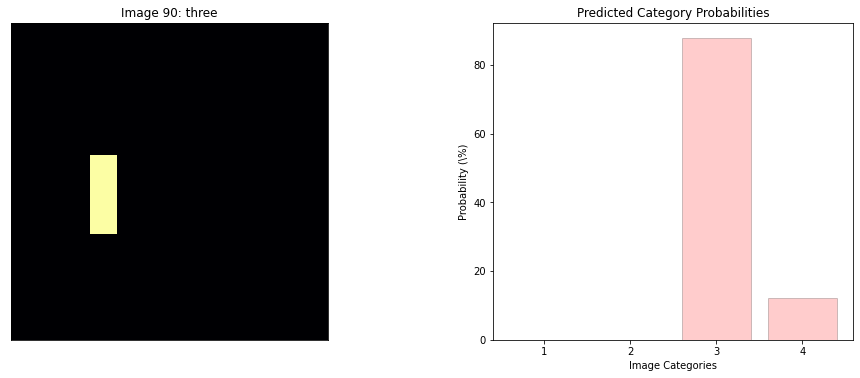

In [49]:
image = 90                                              # selected prediction case image from 0 - 99
visualize_last_layers(model, image)                     # function to visualize the output layer

#### Other Convolutional Neural Network Architecture Examples

Some other examples of layers that could be added to the above CNN

1. More dense layers, ANN feed forward

```python
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
```

2. Max pooling 2D layers

```python
    model.add(layers.MaxPooling2D((2, 2)))
```

#### Visualize the Testing Images and Predicted Classification Probabilities

Let's look at all the testing images and the predicted classification probabilities from our our trained CNN.

* we report the true label, and then the greatest category probability, > 50% (argmax), and the associated category from our CNN 

* for example, 'random, 64% random' indicates a true label of random (first random) and the random (second random) category got the largest predicted probability and that probability was 64%. Given an argmax assignment, this is a correct prediction.

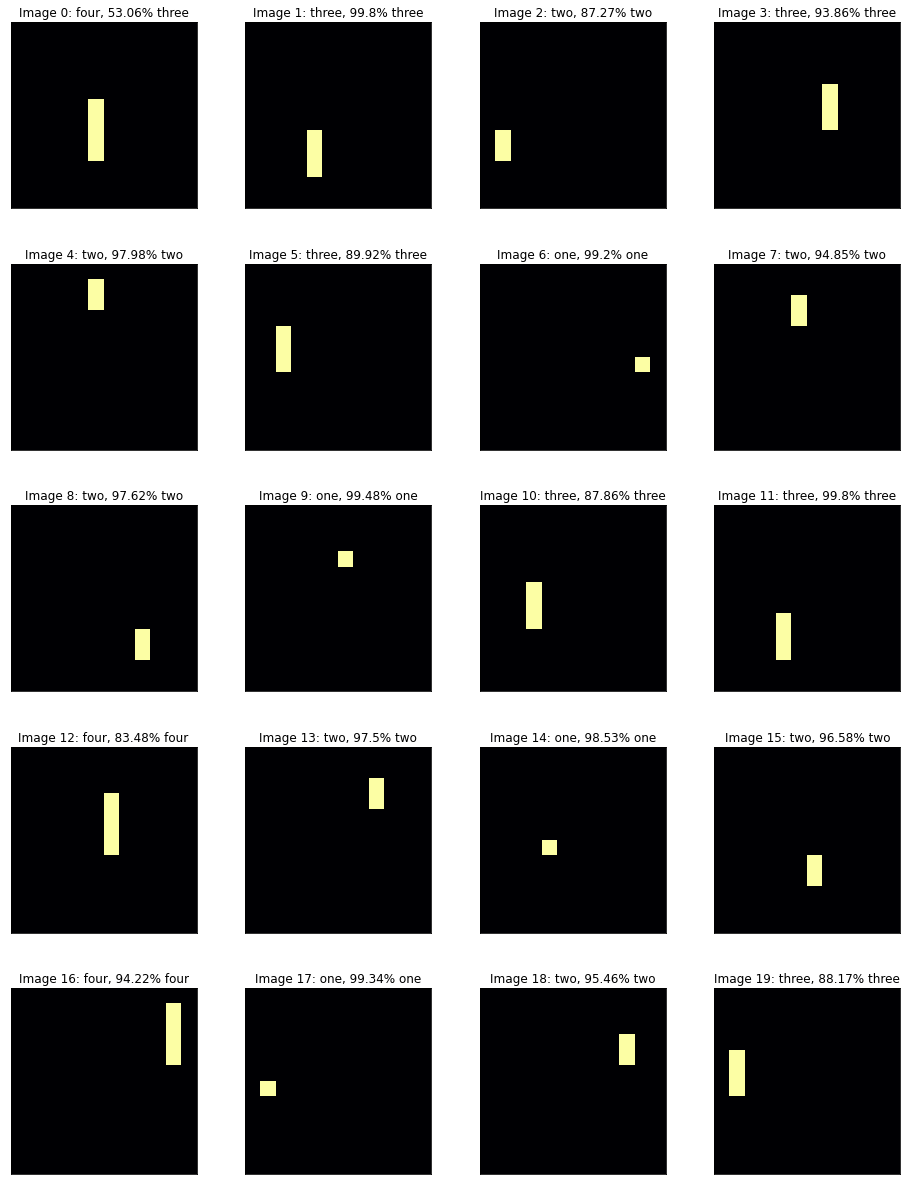

In [50]:
visualize_testing_predictions(model)                    # visualize testing images and probability for correct category

#### Summarize the Performance of our Image Classification CNN

Let's summarize the performance of our CNN over all training and testing images 

* we use boxplots to report the training and testing images prediction probabilities 

* we show the predicted probability of artifact image

* an accurate model has all low probabilities for random images and all high probabilities for artifact images

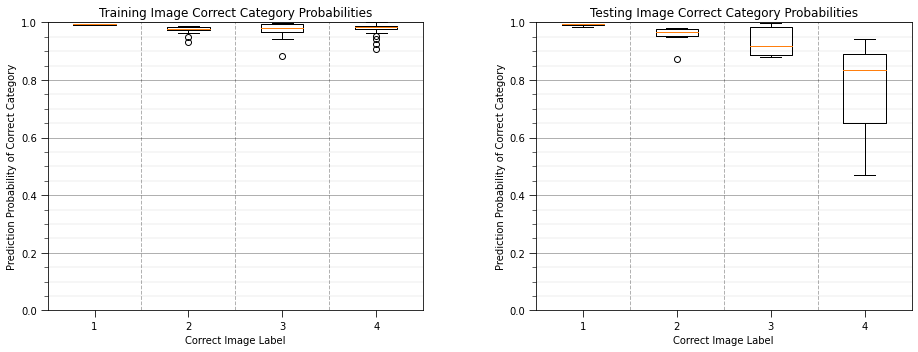

In [51]:
prediction_boxplot(model)                                  # visualize the prediction probability box plots by correct category

#### Comments

This was a very simple convolutional neural network workflow to support experiential learning with fast experientation.  

The Texas Center for Data Analytics and Geostatistics has many other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available [here](https://github.com/GeostatsGuy/PythonNumericalDemos), along with a package for geostatistics in Python called [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy). 
  
We hope this was helpful,

*Michael* and *Honggeun*

***

#### More on Michael Pyrcz and the Texas Center for Data Analytics and Geostatistics:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
